# 反向OO实现自动微分（pytorch核心机制）
1. 使用数据结构Tape来记录计算流程
2. 在反向模式求解梯度的过程中进行replay Operator

流程
1. 操作符重载:预订了特定的数据结构，并对该数据结构重载了相应的基本运算操作符
2. Tape记录:程序在实际执行过程中会将相应表达式的操作类型和输入输出信息记录至特殊数据结构
3. 遍历微分：得到数据结构后，将对数据结构进行遍历并对其中记录的基本运算操作进行微分
4. 链式组合：把结果通过链式法则进行组合，完成自动微分

缺点
1. 需要显示的构造特殊数据结构和对特殊数据结构进行大量读写 遍历，这些额外数据结构和操作对引入不利于高阶微分的实现 科学计算
2. 对于类似if，while等控制流表达式，难以通过操作符重载进行微分规则定义，对于这些操作的处理会退化成基本表达式方法中特定函数封装的方式，难以使用语言原生的控制流表达式

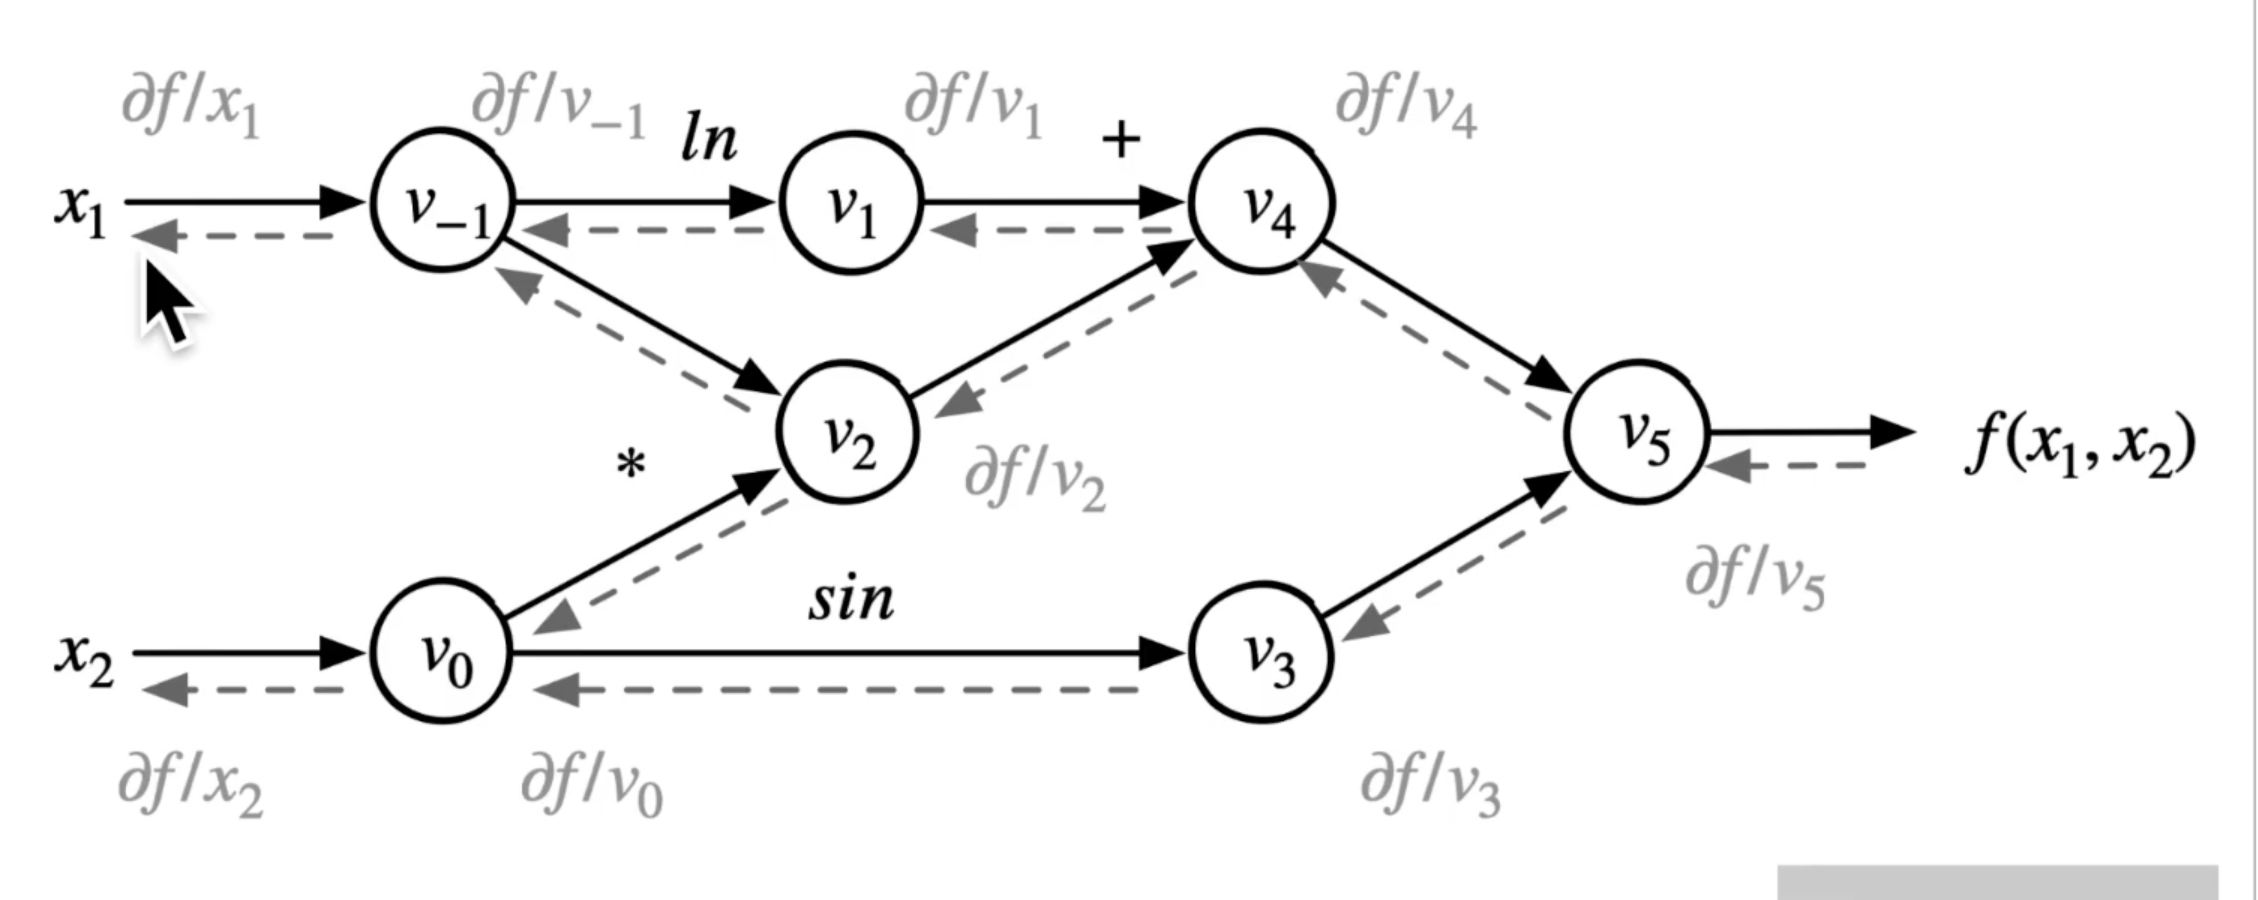

# 反向操作符重载实现
反向模式oo自动微分，上面复杂的反向操作符实现autodiff

In [4]:
from typing import List, NamedTuple, Callable, Dict, Optional
_name = 1
# 打印tape相关的变量
def fresh_name():
    global _name
    name = f'v{_name}'
    _name+=1
    return name

依然是python进行操作符重载，通过Variable来封装跟踪集散的Tensor，每个变量都有一个全局唯一的名称fresh_name,因此也可以在字典中跟踪该变量的梯度，为了便于理解，__init__有时会提供此名称作为参数，否则，每次都会生成一个新的临时值

In [5]:
class Variable:
    def __init__(self, value, name=None):
        self.value = value
        self.name = name or fresh_name()
    
    def __repr__(self):
        return repr(self.value)
        # repr和str都是一样的 一个是print(repr(f)) print(f)

    # We need to start with some tensors whose values were not computed
    # inside the autograd. This function constructs leaf nodes. 
    #打印上下文，把上下的一个值打印出来

    @staticmethod
    def constant(value, name=None):
        var = Variable(value, name)
        print(f'{var.name} = {value}')
        return var
    
    # Multiplication of a Variable, tracking gradients
    def __mul__(self, other):
        return ops_mul(self, other)
    
    def __add__(self, other):
        return ops_add(self, other)
    
    def __sub__(self, other):
        return ops_sub(self, other)
    
    def sin(self):
        return ops_sin(self)
    
    def log(self):
        return ops_log(self)

In [6]:
class Tape(NamedTuple):
    inputs : List[str]
    outputs : List[str]
    # apply chain rule
    # 这边是一个调用方法,  输入一个List 变量， 返回一个List变量
    propagate : 'Callable[List[Variable], List[Variable]]'

In [7]:
gradient_tape : List[Tape] = []

# reset tape
def reset_tape():
    global _name
    _name = 1
    gradient_tape.clear()

In [10]:
import numpy as np
def ops_mul(self, other):
    # forward
    x = Variable(self.value * other.value)
    print(f'{x.name} = {self.name} * {other.name}')
    
    # backward 闭包函数
    def propagate(dl_doutputs):
        dl_dx, = dl_doutputs
        dx_dself = other # partial derivate of r = self*other
        dx_dother = self # partial derivate of r = self*other
        dl_dself = dl_dx * dx_dself
        dl_dother = dl_dx * dx_dother
        dl_dinputs = [dl_dself, dl_dother]
        return dl_dinputs
    
    # record the input and output of the op
    tape = Tape(inputs=[self.name, other.name], outputs=[x.name], propagate=propagate)
    gradient_tape.append(tape)
    return x

In [11]:
def ops_add(self, other):
    x = Variable(self.value + other.value)
    print(f'{x.name} = {self.name} + {other.name}')

    def propagate(dl_doutputs):
        dl_dx, = dl_doutputs
        dx_dself = Variable(1.)
        dx_dother = Variable(1.)
        dl_dself = dl_dx * dx_dself
        dl_dother = dl_dx * dx_dother
        return [dl_dself, dl_dother]
    
    # record the input and output of the op
    tape = Tape(inputs=[self.name, other.name], outputs=[x.name], propagate=propagate)
    gradient_tape.append(tape)
    return x

def ops_sub(self, other):
    x = Variable(self.value - other.value)
    print(f'{x.name} = {self.name} - {other.name}')

    def propagate(dl_doutputs):
        dl_dx, = dl_doutputs
        dx_dself = Variable(1.)
        dx_dother = Variable(-1.)
        dl_dself = dl_dx * dx_dself
        dl_dother = dl_dx * dx_dother
        return [dl_dself, dl_dother]
    
    # record the input and output of the op
    tape = Tape(inputs=[self.name, other.name], outputs=[x.name], propagate=propagate)
    gradient_tape.append(tape)
    return x

def ops_sin(self):
    x = Variable(np.sin(self.value))
    print(f'{x.name} = sin({self.name})')
    
    def propagate(dl_doutputs):
        dl_dx, = dl_doutputs
        dx_dself = Variable(np.cos(self.value))
        dl_dself = dl_dx * dx_dself
        return [dl_dself]
    
    # record the input and output of the op
    tape = Tape(inputs=[self.name], outputs=[x.name], propagate=propagate)
    gradient_tape.append(tape)
    return x

def ops_log(self):
    x = Variable(np.log(self.value))
    print(f'{x.name} = log({self.name})')
    
    def propagate(dl_doutputs):
        dl_dx, = dl_doutputs
        dx_dself = Variable(1 / self.value)
        dl_dself = dl_dx * dx_dself
        return [dl_dself]
    
    # record the input and output of the op
    tape = Tape(inputs=[self.name], outputs=[x.name], propagate=propagate)
    gradient_tape.append(tape)
    return x


In [12]:
def grad(l, results):
    dl_d = {} # map dL/dX for all values X
    dl_d[l.name] = Variable(1.)
    print("dl_d", dl_d)

    def gather_grad(entries):
        return [dl_d[entry] if entry in dl_d else None for entry in entries]
    
    for entry in reversed(gradient_tape):
        print(entry)
        dl_doutputs = gather_grad(entry.outputs)
        dl_dinputs = entry.propagate(dl_doutputs)
        
        for input, dl_dinput in zip(entry.inputs, dl_dinputs):
            if input not in dl_d:
                dl_d[input] = dl_dinput
            else:
                dl_d[input] += dl_dinput
            
    for name, value in dl_d.items():
        print(f'd{l.name}_d{name} = {value.name}')
        
    return gather_grad(result.name for result in results)

In [13]:
reset_tape()

x = Variable.constant(2., name='v-1')
y = Variable.constant(5., name='v0')

f = Variable.log(x) + x * y - Variable.sin(y)
print(f)

v-1 = 2.0
v0 = 5.0
v1 = log(v-1)
v2 = v-1 * v0
v3 = v1 + v2
v4 = sin(v0)
v5 = v3 - v4
11.652071455223084


In [14]:
dx, dy = grad(f, [x, y])
print("dx", dx)
print("dy", dy)

dl_d {'v5': 1.0}
Tape(inputs=['v3', 'v4'], outputs=['v5'], propagate=<function ops_sub.<locals>.propagate at 0x7fc963efd630>)
v9 = v6 * v7
v10 = v6 * v8
Tape(inputs=['v0'], outputs=['v4'], propagate=<function ops_sin.<locals>.propagate at 0x7fc963efd5a0>)
v12 = v10 * v11
Tape(inputs=['v1', 'v2'], outputs=['v3'], propagate=<function ops_add.<locals>.propagate at 0x7fc963efd510>)
v15 = v9 * v13
v16 = v9 * v14
Tape(inputs=['v-1', 'v0'], outputs=['v2'], propagate=<function ops_mul.<locals>.propagate at 0x7fc963efd090>)
v17 = v16 * v0
v18 = v16 * v-1
v19 = v12 + v18
Tape(inputs=['v-1'], outputs=['v1'], propagate=<function ops_log.<locals>.propagate at 0x7fc963efd2d0>)
v21 = v15 * v20
v22 = v17 + v21
dv5_dv5 = v6
dv5_dv3 = v9
dv5_dv4 = v10
dv5_dv0 = v19
dv5_dv1 = v15
dv5_dv2 = v16
dv5_dv-1 = v22
dx 5.5
dy 1.7163378145367738
